<a href="https://colab.research.google.com/github/mapcrafter2048/Literature-Review-Generator-ML-17/blob/main/Literature_Review_Generator_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [2]:
import logging
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq, AdamW
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set logging level
logging.basicConfig(level=logging.ERROR)

In [3]:
# Constants
DATASET_SIZE = 2400000
SAMPLE_FRACTION = 0.004
TRAIN_TEST_SPLIT = 0.1
MAX_INPUT_LENGTH = 512  # Use 512 for T5
MIN_TARGET_LENGTH = 5
MAX_TARGET_LENGTH = 128
BATCH_SIZE = 8
MAX_EPOCHS = 2
MODEL_CHECKPOINT = "t5-small"
SLIDING_WINDOW_OVERLAP = 32  # Adjust as needed

In [4]:
# Load dataset
data = load_dataset("scillm/scientific_papers-archive")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
# Downsample the dataset to 0.4%
sample_size = int(DATASET_SIZE * SAMPLE_FRACTION)
data = data.shuffle(seed=42)
sampled_data = data['train'].train_test_split(train_size=sample_size, seed=42)['train']

In [6]:
# Split the dataset into train and test
train_test_data = sampled_data.train_test_split(test_size=TRAIN_TEST_SPLIT, seed=42)
train_data = train_test_data['train']
test_data = train_test_data['test']

In [7]:
# Load model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [8]:
# Preprocess function
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["input"]]
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for input_text in inputs:
        encoded_segments = tokenizer(input_text, max_length=MAX_INPUT_LENGTH, truncation=True, padding="max_length", return_tensors="np")
        all_input_ids.append(encoded_segments["input_ids"].tolist())
        all_attention_masks.append(encoded_segments["attention_mask"].tolist())

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["output"], max_length=MAX_TARGET_LENGTH, truncation=True, padding="max_length", return_tensors="np")
        for label in labels["input_ids"]:
            all_labels.append(label.tolist())

    model_inputs = {
        "input_ids": all_input_ids,
        "attention_mask": all_attention_masks,
        "labels": all_labels,
    }
    return model_inputs

# Apply preprocessing
tokenized_train = train_data.map(preprocess_function, batched=True, remove_columns=["input", "output"])
tokenized_test = test_data.map(preprocess_function, batched=True, remove_columns=["input", "output"])

# Fix column lengths
def fix_column_length(dataset, column_name, expected_length):
    def fix_length(example):
        example[column_name] = example[column_name] + [0] * (expected_length - len(example[column_name]))
        return example

    return dataset.map(lambda example: fix_length(example), batched=True)

train_data_fixed = fix_column_length(tokenized_train, "input_ids", MAX_INPUT_LENGTH)
test_data_fixed = fix_column_length(tokenized_test, "input_ids", MAX_INPUT_LENGTH)

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.input_ids = torch.tensor(data["input_ids"])
        self.attention_mask = torch.tensor(data["attention_mask"])
        self.labels = torch.tensor(data["labels"])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = CustomDataset(train_data_fixed)
test_dataset = CustomDataset(test_data_fixed)

Map:   0%|          | 0/8640 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/8640 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [9]:
# DataLoader creation
def create_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
test_dataloader = create_dataloader(test_dataset, BATCH_SIZE)

In [10]:
# Setup for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
def train():
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if labels.shape[0] == 0:
            continue

        input_ids = input_ids.view(input_ids.size(0), -1)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_dataloader)

# Evaluation loop
def evaluate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            if labels.shape[0] == 0:
                continue

            input_ids = input_ids.view(input_ids.size(0), -1)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
    return total_loss / len(test_dataloader)

# Training and evaluation
for epoch in range(MAX_EPOCHS):
    print(f"Epoch {epoch + 1}/{MAX_EPOCHS}")
    train_loss = train()
    print(f"Training Loss: {train_loss:.4f}")

    eval_loss = evaluate()
    print(f"Evaluation Loss: {eval_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2


Training:   0%|          | 0/1080 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Training: 100%|██████████| 1080/1080 [06:11<00:00,  2.91it/s]


Training Loss: 2.7887


Evaluating: 100%|██████████| 120/120 [00:14<00:00,  8.31it/s]


Evaluation Loss: 2.3609
Epoch 2/2


Training: 100%|██████████| 1080/1080 [06:13<00:00,  2.89it/s]


Training Loss: 2.4472


Evaluating: 100%|██████████| 120/120 [00:14<00:00,  8.35it/s]

Evaluation Loss: 2.2714


In [11]:
# De-duplication function
def remove_duplicates(text_list):
    unique_text = []
    vectorizer = TfidfVectorizer().fit_transform(text_list)
    cosine_sim = cosine_similarity(vectorizer)
    for i in range(len(text_list)):
        if not any(cosine_sim[i, j] > 0.9 for j in range(i)):
            unique_text.append(text_list[i])
    return unique_text

In [12]:
# Review generation with de-duplication
def generate_review(text, model, tokenizer, max_input_length=512, max_target_length=128):
    def sliding_window(text, max_length, overlap):
        tokens = tokenizer.encode(text, truncation=False)
        segments = []
        start = 0
        while start < len(tokens):
            end = min(start + max_length, len(tokens))
            segment = tokens[start:end]
            decoded_segment = tokenizer.decode(segment, skip_special_tokens=True)
            segments.append(decoded_segment)
            if end == len(tokens):
                break
            start += max_length - overlap
        return segments

    segments = sliding_window(text, max_input_length, SLIDING_WINDOW_OVERLAP)
    reviews = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            encoded_segment = tokenizer(segment, return_tensors="pt", max_length=max_input_length, truncation=True, padding="max_length").to(device)
            outputs = model.generate(
                input_ids=encoded_segment["input_ids"],
                attention_mask=encoded_segment["attention_mask"],
                max_length=max_target_length,
                num_beams=6,
                early_stopping=True
            )
            reviews.append(tokenizer.decode(outputs[0], skip_special_tokens=True))

    combined_review = ' '.join(reviews)
    review_sentences = combined_review.split('. ')
    unique_review_sentences = remove_duplicates(review_sentences)

    return ''.join(unique_review_sentences)

In [13]:
# Audio for Summary
!pip install pyttsx3
!pip install gtts
!sudo apt-get install espeak

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,382 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak-data amd64 1.48.15+dfsg-3 [1,085 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libespeak1 amd64 1.48.15+dfsg-3 [156 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak amd64 1.48.15+dfsg-3 [64.2 kB]
Fetched 1,382 kB in 1s (2,037 

In [14]:
from gtts import gTTS
from IPython.display import Audio

def text_to_speech(text, filename="output.mp3"):
    tts = gTTS(text=text, lang='en')  # Convert text to speech
    tts.save(filename)  # Save the speech to a file
    return filename

In [15]:
# Keywords WordCloud for Summary
!pip install rake-nltk wordcloud
!pip install rake-nltk wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from rake_nltk import Rake
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
# Function to extract keywords from a paragraph
def extract_keywords(paragraph):
    rake = Rake()
    rake.extract_keywords_from_text(paragraph)
    keywords = rake.get_ranked_phrases()
    return keywords

# Function to generate a word cloud from keywords
def generate_wordcloud(keywords):
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (1146 > 512). Running this sequence through the model will result in indexing errors


The Mars Perseverance rover is a significant advancement in Mars exploration. Recent Achievements The Mars Perseverance Rover Launched on July 30, 2020, NASA's Perseverance rover represents a significant advancement in Mars exploration. The Perseverance rover aims to search for signs of ancient life and assess the planet's geological history. The Mars Perseverance Rovers landed on Mars in January 2004 and culminated with Apollo 17 in 1972. The Perseverance  . is a spacecraft designed to observe the universe in infrared wavelengths, allowing it to peer through dust clouds and observe the formation of the earliest galaxies. Its observations are expected to provide critical insights into cosmic origins, stellar evolution, and exoplanetary systems. Technological Innovations NASA's future missions will continue to push the boundaries of exploration and scientific discovery. Future Prospects NASA's future missions will continue to push the boundaries of exploration and scientific discovery. 

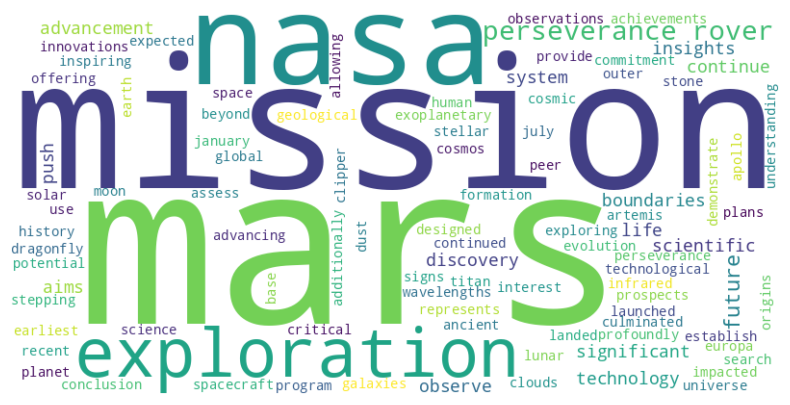

In [17]:
text="""Introduction
NASA, the United States' premier space agency, has been at the forefront of space exploration and scientific discovery since its establishment in 1958. Over the decades, NASA's missions have significantly expanded human understanding of space, technology, and Earth. This paper provides an overview of key NASA missions, emphasizing their achievements, scientific contributions, and future directions.

Historical Context and Major Milestones
The Apollo Program
One of NASA's most iconic endeavors is the Apollo program, which began with Apollo 1 in 1967 and culminated with Apollo 17 in 1972. The program's primary objective was to land humans on the Moon and return them safely to Earth. The Apollo 11 mission, launched on July 16, 1969, achieved this goal, with astronauts Neil Armstrong and Buzz Aldrin becoming the first humans to walk on the lunar surface. The program yielded a wealth of scientific data and lunar samples, greatly enhancing our understanding of lunar geology and the solar system's formation.

The Space Shuttle Era
Following the Apollo program, NASA embarked on the Space Shuttle program, which began with the launch of Columbia in 1981. The shuttle program was characterized by its reusable spacecraft, which facilitated the deployment and servicing of satellites, as well as the construction and operation of the International Space Station (ISS). Notable missions include the deployment of the Hubble Space Telescope in 1990, which has provided unprecedented views of the universe and contributed to our understanding of cosmic phenomena.

The Mars Exploration Rovers
In the early 2000s, NASA's focus shifted to Mars exploration. The Mars Exploration Rovers, Spirit and Opportunity, landed on Mars in January 2004. These rovers were designed to search for signs of past water activity and assess the planet's geological history. Their discoveries, including evidence of ancient water flows and diverse mineralogy, have been pivotal in shaping our understanding of Mars and its potential for past life.

Recent Achievements
The Mars Perseverance Rover
Launched on July 30, 2020, NASA's Perseverance rover represents a significant advancement in Mars exploration. Equipped with a suite of scientific instruments and a helicopter named Ingenuity, Perseverance aims to search for signs of ancient life and collect samples for future return to Earth. Ingenuity's successful flights marked the first powered flight on another planet, showcasing technological advancements in autonomous aerial exploration.

The James Webb Space Telescope
Launched on December 25, 2021, the James Webb Space Telescope (JWST) is the successor to the Hubble Space Telescope. Positioned at the second Lagrange point (L2), JWST is designed to observe the universe in infrared wavelengths, allowing it to peer through dust clouds and observe the formation of the earliest galaxies. Its observations are expected to provide critical insights into cosmic origins, stellar evolution, and exoplanetary systems.

The Artemis Program
In 2020, NASA initiated the Artemis program with the goal of returning humans to the Moon and establishing a sustainable presence there. Artemis I, an uncrewed mission, successfully tested the Space Launch System (SLS) and the Orion spacecraft. The program aims to land the first woman and the next man on the lunar surface and establish a lunar base to facilitate future exploration of Mars.

Technological Innovations
NASA missions have driven numerous technological advancements. The development of the Space Shuttle’s reusable technology, the miniaturization of scientific instruments for rovers, and innovations in propulsion systems are just a few examples. Technologies developed for space missions have found applications in other fields, such as medical imaging, materials science, and telecommunications.

Scientific Contributions
NASA missions have provided invaluable scientific data across various domains:

Planetary Science: Missions to Mars, Jupiter, and Saturn have offered insights into planetary atmospheres, geology, and potential habitability. The discovery of subsurface oceans on moons like Europa and Enceladus raises the possibility of extraterrestrial life.

Astronomy and Cosmology: Telescopes like Hubble and JWST have revolutionized our understanding of the universe's structure, the formation of galaxies, and the nature of dark matter and dark energy.

Earth Science: NASA’s Earth-observing satellites monitor climate change, natural disasters, and environmental changes. Missions like the Earth Observing System (EOS) have been instrumental in tracking atmospheric composition and land use.

Future Prospects
Looking ahead, NASA's future missions will continue to push the boundaries of exploration and scientific discovery. The Artemis program aims to establish a lunar base and use the Moon as a stepping stone for human missions to Mars. Additionally, NASA's plans for the Europa Clipper mission and the Dragonfly mission to Titan demonstrate a continued commitment to exploring the outer solar system and understanding the potential for life beyond Earth.

Conclusion
NASA’s missions have profoundly impacted science and technology, offering insights into the cosmos, advancing space technology, and inspiring global interest in exploration. From the historic Apollo Moon landings to the groundbreaking work of the James Webb Space Telescope, NASA’s achievements illustrate the agency’s dedication to expanding human knowledge and capability. As NASA continues to pursue ambitious goals, the future promises further discoveries and innovations that will continue to shape our understanding of the universe and our place within it."""
review = generate_review(text, model, tokenizer)
print(review + "\n")
keywords = extract_keywords(review)
generate_wordcloud(keywords)
audio_file = text_to_speech(review)
Audio(audio_file)

. Quantum computing is an emerging field that promises to revolutionize various aspects of science, technology, and industry by exploiting the unique principles of quantum mechanics. At its core, quantum technology leverages phenomena such as superposition, entanglement, and quantum tunneling, which have no counterparts in classical physics. Quantum computing is a promising field that promises to revolutionize . Quantum sensors can detect minute changes in magnetic fields, gravitational forces, and other environmental factors with extreme sensitivity. Quantum sensors could improve the accuracy of gyroscopes and accelerometers, providing more accurate guidance for autonomous vehicles and spacecraft. . Quantum technology is a frontier of scientific and technological innovation with the potential to transform fields. The global race to develop quantum technology is well underway, with significant investments from governments, private companies, and research institutions. This competitive 

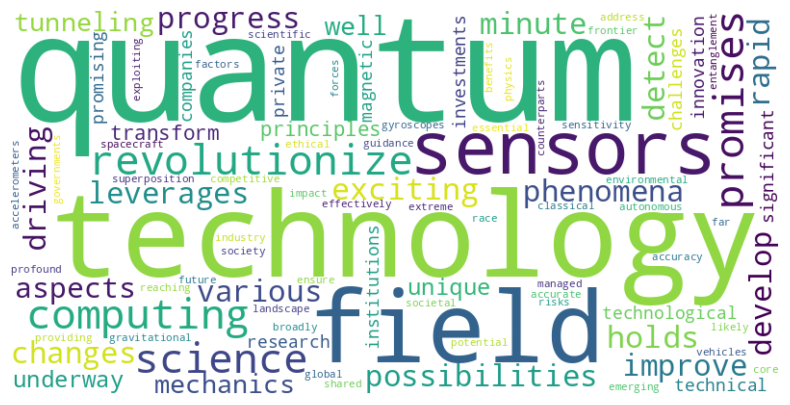

In [18]:
text="""Quantum technology is an emerging field that promises to revolutionize various aspects of science, technology, and industry by exploiting the unique principles of quantum mechanics. At its core, quantum technology leverages phenomena such as superposition, entanglement, and quantum tunneling, which have no counterparts in classical physics. These phenomena enable unprecedented capabilities in computing, communication, and sensing, potentially transforming fields from cryptography to medicine.

Quantum computing is perhaps the most well-known aspect of quantum technology. Unlike classical computers, which use bits to process information in binary states of 0s and 1s, quantum computers use quantum bits, or qubits. Qubits can exist simultaneously in multiple states due to the principle of superposition. This allows quantum computers to perform many calculations at once, exponentially increasing their processing power for certain types of problems. Additionally, qubits can be entangled, meaning the state of one qubit is dependent on the state of another, regardless of the distance between them. This entanglement enables quantum computers to solve complex problems that are currently intractable for classical computers, such as factoring large numbers, simulating molecular structures, and optimizing complex systems. The potential applications of quantum computing are vast and varied. In cryptography, quantum computers could break traditional encryption methods, which rely on the difficulty of factoring large numbers, necessitating the development of new, quantum-resistant encryption algorithms. In chemistry and material science, quantum computers can simulate the behavior of molecules at the quantum level, aiding in the design of new materials and drugs. In logistics and supply chain management, quantum algorithms can optimize routes and resources, improving efficiency and reducing costs. However, building a practical, large-scale quantum computer is a monumental challenge. Qubits are highly susceptible to environmental noise and decoherence, which can cause them to lose their quantum state. This fragility necessitates sophisticated error correction methods and extremely low-temperature environments to maintain qubit stability. Researchers are exploring various physical implementations of qubits, including superconducting circuits, trapped ions, and topological qubits, each with its own set of advantages and challenges.

Quantum communication is another promising application of quantum technology, offering theoretically unbreakable encryption through quantum key distribution (QKD). QKD leverages the principles of quantum mechanics to create a secure communication channel. Any attempt to eavesdrop on the channel would disturb the quantum states being transmitted, alerting the communicating parties to the presence of an intruder. This level of security is unattainable with classical communication methods. Quantum networks, which extend QKD across larger distances, are currently being developed. These networks rely on quantum repeaters to overcome the loss and decoherence of quantum signals over long distances. Quantum communication could revolutionize secure communications, protecting sensitive information in fields such as finance, government, and healthcare. The development of quantum internet, where quantum information is transmitted and processed across a network of interconnected quantum devices, is a long-term goal that could enable new applications and services not possible with classical internet.

Quantum sensing and metrology leverage quantum phenomena to achieve unprecedented levels of precision in measuring physical quantities. Quantum sensors can detect minute changes in magnetic fields, gravitational forces, and other environmental factors with extreme sensitivity. This capability has applications in various fields, including medical imaging, navigation, and geophysical exploration. For example, quantum sensors could improve the accuracy of MRI machines, enabling earlier detection of diseases. In navigation, quantum sensors could enhance the precision of gyroscopes and accelerometers, providing more accurate guidance for autonomous vehicles and spacecraft. In geophysical exploration, quantum sensors could detect subtle variations in the Earth's gravitational field, aiding in the discovery of natural resources. Despite the promise of quantum technology, significant technical and engineering challenges remain. Ensuring the stability and coherence of qubits, developing scalable quantum architectures, and integrating quantum systems with existing technologies are ongoing areas of research. Additionally, the field faces challenges in terms of standardization, interoperability, and the development of a skilled workforce capable of advancing quantum technology.

The ethical and societal implications of quantum technology are also important considerations. The potential to break existing encryption methods raises concerns about data security and privacy. As quantum technology advances, it will be crucial to develop new cryptographic techniques and policies to safeguard sensitive information. Moreover, the development and deployment of quantum technologies will likely require significant investment and international collaboration, raising questions about access, equity, and the distribution of benefits. As with any transformative technology, it is essential to ensure that the advantages of quantum technology are widely shared and that potential risks are mitigated.

The global race to develop quantum technology is well underway, with significant investments from governments, private companies, and research institutions. Countries such as the United States, China, and members of the European Union have launched national initiatives to advance quantum research and development. Major technology companies, including IBM, Google, and Microsoft, are also investing heavily in quantum computing and related technologies. This competitive landscape is driving rapid progress, but it also underscores the need for international cooperation and collaboration to address the complex challenges and maximize the benefits of quantum technology.

In conclusion, quantum technology represents a frontier of scientific and technological innovation with the potential to transform a wide range of fields. Quantum computing promises to revolutionize information processing, enabling solutions to problems that are currently unsolvable. Quantum communication offers unparalleled security for transmitting information, and quantum sensing and metrology provide unprecedented precision in measurement. While significant challenges remain in realizing the full potential of quantum technology, ongoing research and development efforts are steadily advancing the field. As quantum technology continues to evolve, it will be essential to address the ethical, societal, and technical challenges to ensure that its benefits are broadly shared and its risks are effectively managed. The future of quantum technology holds exciting possibilities, and its impact on science, technology, and society is likely to be profound and far-reaching."""
review = generate_review(text, model, tokenizer)
print(review + "\n")
keywords = extract_keywords(review)
generate_wordcloud(keywords)
audio_file = text_to_speech(review)
Audio(audio_file)

electronics: Current Trends and Future Prospects Abstract Nanoelectronics, the application of nanotechnology in electronic components, is revolutionizing the field of electronics by enabling the development of smaller, faster, and more efficient devices. Introduction Nanoelectronics, a subfield of nanotechnology, focuses on the use of nanoscale materials and techniques to develop electronic devices. Introduction Nanoelectronics involves the manipulation of electrons and photons at the nanometer scale, where quantum mechanical effects become significant. electronics Transistors and Integrated Circuits FinFETs: Microelectronics Transistors (MEMS) and nanoelectromechanical systems (NEMS) integrate mechanical and electronic components at the microscale and nanoscale for applications in healthcare, automotive, and consumer electronics. Microelectromechanical systems (MEMS) and nanoelectromechanical systems (NEMS) integrate mechanical and electronic components at the microscale and nanoscale

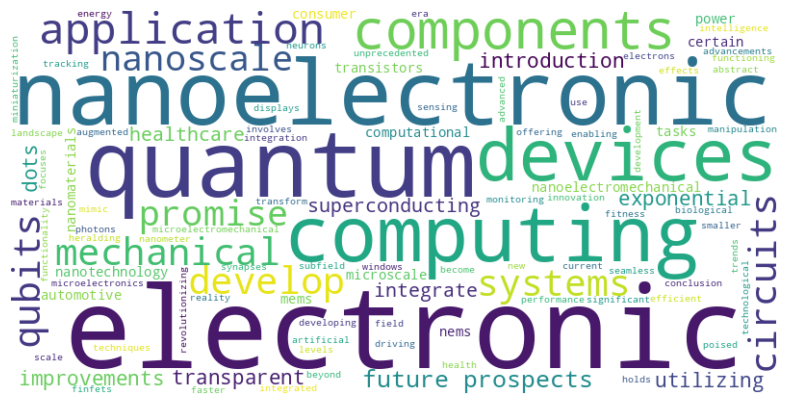

In [22]:
text="""Title: Advances in Nanoelectronics: Current Trends and Future Prospects
Abstract
Nanoelectronics, the application of nanotechnology in electronic components, is revolutionizing the field of electronics by enabling the development of smaller, faster, and more efficient devices. This paper explores the fundamental concepts, recent advancements, current applications, and future prospects of nanoelectronics. It highlights the challenges and potential solutions in this rapidly evolving field, aiming to provide a comprehensive overview for researchers and industry professionals.

Introduction
Nanoelectronics, a subfield of nanotechnology, focuses on the use of nanoscale materials and techniques to develop electronic devices. The field has garnered significant attention due to its potential to surpass the limitations of traditional semiconductor technologies. By manipulating materials at the atomic and molecular levels, nanoelectronics aims to achieve unprecedented levels of performance and functionality. This paper delves into the foundational principles of nanoelectronics, recent breakthroughs, current applications, and future directions.

Fundamental Concepts of Nanoelectronics
Nanoelectronics involves the manipulation of electrons and photons at the nanometer scale, where quantum mechanical effects become significant. Key concepts include:

Quantum Confinement: At the nanoscale, electrons are confined to very small spaces, leading to quantized energy levels and unique electronic properties.
Tunneling: Quantum tunneling allows electrons to pass through barriers that would be insurmountable at larger scales, enabling novel device architectures.
Coulomb Blockade: This phenomenon occurs when the addition of a single electron to a nanostructure significantly alters its electrical properties, allowing for single-electron transistors.
Recent Advancements in Nanoelectronics

Graphene and 2D Materials

Graphene: A single layer of carbon atoms arranged in a hexagonal lattice, graphene exhibits exceptional electrical, thermal, and mechanical properties. Its high electron mobility makes it a promising candidate for high-speed transistors and sensors.
Transition Metal Dichalcogenides (TMDs): These 2D materials, such as MoS2 and WS2, have tunable bandgaps and can be used to create flexible, transparent electronics.
Nanowires and Nanotubes

Silicon Nanowires: Silicon nanowires offer high surface-to-volume ratios and can be used in field-effect transistors (FETs) with superior performance characteristics.
Carbon Nanotubes (CNTs): CNTs possess excellent electrical conductivity and mechanical strength, making them suitable for transistors, interconnects, and nanoscale sensors.
Molecular Electronics

Single-Molecule Devices: Researchers are exploring the use of individual molecules as electronic components, such as switches and diodes, to achieve ultra-miniaturization.
Self-Assembling Monolayers (SAMs): These organic molecules can form ordered structures on surfaces, enabling the creation of nanoscale circuits and memory devices.
Quantum Dots and Nanocrystals

Quantum Dots: These semiconductor nanoparticles exhibit size-dependent optical and electronic properties, useful in applications like quantum computing and bioimaging.
Colloidal Nanocrystals: Solution-processed nanocrystals can be used to fabricate low-cost, high-performance electronic and optoelectronic devices.
Current Applications of Nanoelectronics

Transistors and Integrated Circuits

FinFETs: Fin Field-Effect Transistors are widely used in advanced integrated circuits due to their improved control over short-channel effects.
Quantum Dot Cellular Automata (QCA): QCA represents a paradigm shift in computing, utilizing the positions of quantum dots to represent binary information.
Sensors and Actuators

Nanoscale Sensors: Nanoelectronic sensors offer high sensitivity and selectivity for detecting chemical and biological agents, environmental pollutants, and physical parameters.
MEMS and NEMS: Microelectromechanical systems (MEMS) and nanoelectromechanical systems (NEMS) integrate mechanical and electronic components at the microscale and nanoscale for applications in healthcare, automotive, and consumer electronics.
Energy Harvesting and Storage

Nanogenerators: Devices that convert mechanical energy into electrical energy using piezoelectric and triboelectric effects.
Supercapacitors: Nanoengineered materials enhance the energy storage capacity and charge/discharge rates of supercapacitors.
Optoelectronics

Photodetectors: Nanomaterials like quantum dots and perovskites are used to create highly sensitive photodetectors for imaging and communication.
LEDs and Lasers: Nanoelectronics enables the development of efficient, tunable light-emitting diodes (LEDs) and lasers for displays and optical communication.
Challenges and Potential Solutions

Fabrication and Scalability

Top-Down vs. Bottom-Up Approaches: Combining traditional lithography (top-down) with chemical synthesis and self-assembly (bottom-up) to achieve precise nanoscale fabrication.
Defect Control: Developing methods to minimize and manage defects in nanomaterials to ensure device reliability and performance.
Integration with Existing Technologies

Hybrid Systems: Integrating nanoelectronic components with conventional silicon-based technology to create hybrid systems that leverage the strengths of both approaches.
Interface Engineering: Ensuring efficient and stable interfaces between nanomaterials and other device components.
Power Consumption and Heat Management

Low-Power Design: Utilizing novel materials and device architectures to reduce power consumption in nanoelectronic devices.
Thermal Management: Developing advanced cooling techniques and thermally conductive materials to dissipate heat generated by high-density nanoelectronic circuits.
Economic and Environmental Impact

Cost-Effective Manufacturing: Scaling up production methods to reduce costs and make nanoelectronics commercially viable.
Sustainable Practices: Promoting environmentally friendly materials and processes to mitigate the ecological impact of nanoelectronics manufacturing and disposal.
Future Prospects

Quantum Computing

Qubits: Utilizing quantum dots, superconducting circuits, and other nanomaterials to develop qubits for quantum computing, which promises exponential improvements in computational power for certain tasks.
Quantum Communication: Exploring secure communication methods based on quantum entanglement and quantum key distribution.
Neuromorphic Computing

Brain-Inspired Circuits: Developing nanoelectronic devices that mimic the functioning of biological neurons and synapses for advanced artificial intelligence applications.
Memristors: Using nanoscale resistive switching devices to create memory elements that can emulate synaptic plasticity.
Flexible and Wearable Electronics

Stretchable Circuits: Creating electronics that can be integrated into fabrics and wearable devices for health monitoring, fitness tracking, and augmented reality.
Transparent Electronics: Developing transparent nanoelectronic components for seamless integration into displays and windows.
Conclusion
Nanoelectronics is poised to transform the landscape of electronic devices, offering unprecedented levels of miniaturization, performance, and functionality. While significant challenges remain in terms of fabrication, integration, and scalability, ongoing research and development efforts are paving the way for innovative solutions. As the field continues to evolve, nanoelectronics holds the promise of driving advancements in computing, sensing, energy, and beyond, heralding a new era of technological innovation."""
review = generate_review(text, model, tokenizer)
print(review + "\n")
keywords = extract_keywords(review)
generate_wordcloud(keywords)
audio_file = text_to_speech(review)
Audio(audio_file)

and ML Healthcare: AI and ML have experienced unprecedented growth in recent years, transforming numerous sectors including healthcare, finance, and transportation. Abstract Artificial Intelligence (AI) and Machine Learning (ML) have experienced unprecedented growth in recent years, transforming numerous sectors including healthcare, finance, and transportation. Abstract Artificial Intelligence (AI) and Machine Learning (ML) have and ML Healthcare: AI and ML have made significant strides in healthcare, from diagnostics to personalized medicine. AI-driven robo-advisors analyze medical images to detect diseases such as cancer and diabetic retinopathy. AI-driven platforms analyze medical images to detect diseases such as cancer and diabetic retinopathy. and the future of work: AI and ML are rapidly evolving, with ongoing research focusing on improving model efficiency, scalability, and generalization. Ethical AI Development: As AI continues to evolve, it is imperative to prioritize ethica

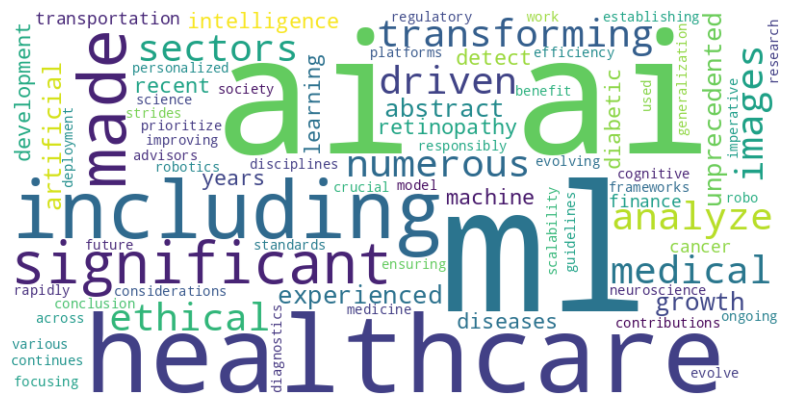

In [20]:
text="""Abstract
Artificial Intelligence (AI) and Machine Learning (ML) have experienced unprecedented growth in recent years, transforming numerous sectors including healthcare, finance, and transportation. This paper explores the current advancements in AI and ML, their practical applications, and the challenges associated with these technologies. By reviewing recent literature and case studies, the paper aims to provide a comprehensive overview of the state-of-the-art technologies, their implications, and future directions.

Introduction
Artificial Intelligence (AI) encompasses a broad range of technologies designed to perform tasks that typically require human intelligence. Machine Learning (ML), a subset of AI, focuses on algorithms that enable systems to learn from data and improve over time. The intersection of AI and ML has led to significant advancements, impacting various domains through applications such as natural language processing, computer vision, and autonomous systems.

Advancements in AI and ML
Deep Learning:
Deep Learning (DL), a subset of ML, has revolutionized the field by leveraging neural networks with multiple layers to model complex patterns in data. Convolutional Neural Networks (CNNs) have achieved remarkable success in image and video recognition tasks. Recurrent Neural Networks (RNNs) and Transformers have significantly advanced natural language processing (NLP), enabling systems to understand and generate human language with greater accuracy.

Reinforcement Learning:
Reinforcement Learning (RL) involves training models through interactions with their environment to maximize cumulative rewards. Recent advancements in RL have led to breakthroughs in game playing, robotic control, and autonomous driving. Notable examples include AlphaGo's victory over human champions and advancements in self-driving car technologies.

Generative Models:
Generative models, such as Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs), have gained attention for their ability to generate new, synthetic data from learned distributions. These models are used in applications ranging from image synthesis to drug discovery and design.

Transfer Learning:
Transfer Learning involves applying knowledge gained from one domain to a different but related domain. This technique has made it possible to build high-performance models with relatively small amounts of data by leveraging pre-trained models.

Applications of AI and ML
Healthcare:
AI and ML have made significant strides in healthcare, from diagnostics to personalized medicine. ML algorithms analyze medical images to detect diseases such as cancer and diabetic retinopathy. AI-driven platforms also assist in predicting patient outcomes and personalizing treatment plans. For example, IBM Watson for Oncology provides treatment recommendations based on vast amounts of medical literature and patient data.

Finance:
In the financial sector, AI and ML are used for fraud detection, algorithmic trading, and credit scoring. Machine learning models analyze transaction patterns to identify fraudulent activities and reduce financial risks. AI-driven robo-advisors provide personalized investment advice, optimizing portfolios based on individual risk profiles and market conditions.

Transportation:
Autonomous vehicles represent a significant application of AI and ML. Self-driving cars use a combination of computer vision, sensor data, and reinforcement learning to navigate and make driving decisions. Additionally, AI algorithms optimize logistics and supply chain management by predicting demand, routing deliveries, and managing inventory.

Customer Service:
AI-powered chatbots and virtual assistants have transformed customer service by providing 24/7 support and handling a wide range of inquiries. Natural language processing allows these systems to understand and respond to customer queries in real-time, improving customer satisfaction and operational efficiency.

Challenges and Ethical Considerations
Data Privacy and Security:
The effectiveness of AI and ML heavily relies on the availability of large datasets. However, this raises concerns about data privacy and security. Ensuring that data is handled responsibly and that individuals' privacy is protected is crucial. Techniques such as differential privacy and federated learning are being developed to address these concerns.

Bias and Fairness:
AI systems can perpetuate and even exacerbate existing biases present in training data. Ensuring fairness and mitigating bias in AI systems is a critical challenge. Researchers are working on developing algorithms and practices to detect and correct bias, but achieving unbiased AI remains an ongoing challenge.

Explainability and Transparency:
Many advanced AI models, particularly deep learning networks, operate as "black boxes," making it difficult to understand how they arrive at their decisions. Improving the explainability and transparency of AI systems is essential for trust and accountability, especially in high-stakes applications like healthcare and finance.

Job Displacement:
The automation of tasks through AI and ML raises concerns about job displacement and the future of work. While AI has the potential to create new job opportunities, it also necessitates reskilling and upskilling of the workforce to adapt to the changing job landscape.

Future Directions
Continued Innovation:
The field of AI and ML is rapidly evolving, with ongoing research focusing on improving model efficiency, scalability, and generalization. Innovations such as quantum computing and neuromorphic engineering may further accelerate advancements in AI.

Interdisciplinary Approaches:
The integration of AI with other disciplines, such as cognitive science, neuroscience, and robotics, holds promise for developing more sophisticated and adaptable systems. Collaborative research across these fields can lead to new insights and applications.

Ethical AI Development:
As AI continues to evolve, it is imperative to prioritize ethical considerations in its development and deployment. Establishing guidelines, standards, and regulatory frameworks will be crucial in ensuring that AI technologies are used responsibly and for the benefit of society.

Conclusion
AI and ML have already made significant contributions across various domains, demonstrating their transformative potential. As technology continues to advance, it is essential to address the associated challenges and ethical considerations to ensure that AI and ML benefit society as a whole. Ongoing research, interdisciplinary collaboration, and responsible development practices will play a key role in shaping the future of these technologies."""
review = generate_review(text, model, tokenizer)
print(review + "\n")
keywords = extract_keywords(review)
generate_wordcloud(keywords)
audio_file = text_to_speech(review)
Audio(audio_file)